# DBSCAN

## Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

from collections import deque

In [2]:
class DBSCAN(object):
    UNCLASSIFIED = -2
    NOISE = -1
    
    def __init__(self, eps=0.5, min_pts=5):
        self.eps = eps
        self.min_pts = min_pts

    def fit(self, X):
        labels = np.full([X.shape[0]], DBSCAN.UNCLASSIFIED)
        return self._fit(X, labels)

    def _fit(self, X, labels):
        cluster_id = DBSCAN._next_id(DBSCAN.NOISE)
        for point_ind in range(X.shape[0]):
            if labels[point_ind] == DBSCAN.UNCLASSIFIED:
                if self._expand_cluster(X, labels, point_ind, cluster_id):
                    cluster_id = DBSCAN._next_id(cluster_id)
        return labels

    def _expand_cluster(self, X, labels, point_ind, cluster_id):
        region_inds = self._region_query(X, point_ind)
        if len(region_inds) < self.min_pts:
            labels[point_ind] = DBSCAN.NOISE
            return False

        # label these points to cluseter_id
        labels[region_inds] = cluster_id
        labels[point_ind] = cluster_id

        queue_inds = deque(region_inds)
        while len(queue_inds):
            current_point_ind = queue_inds.popleft()

            result = self._region_query(X, current_point_ind)
            if len(result) > self.min_pts:
                is_noise = labels[result] == DBSCAN.NOISE
                is_unclassified = labels[result] == DBSCAN.UNCLASSIFIED
                
                # we add only unclussified points
                queue_inds.extend(result[is_unclassified])
                # label these points to cluseter_id
                labels[result[np.logical_or(is_noise, is_unclassified)]] = cluster_id
        return True

    def _region_query(self, X, point_ind):
        d = np.sqrt(np.sum((X - X[point_ind]) ** 2, axis=1))
        mask = d < self.eps
        mask[point_ind] = False  # exclude this point
        return np.where(mask)[0]

    @staticmethod
    def _next_id(cluster_id):
        return cluster_id + 1


## Testing

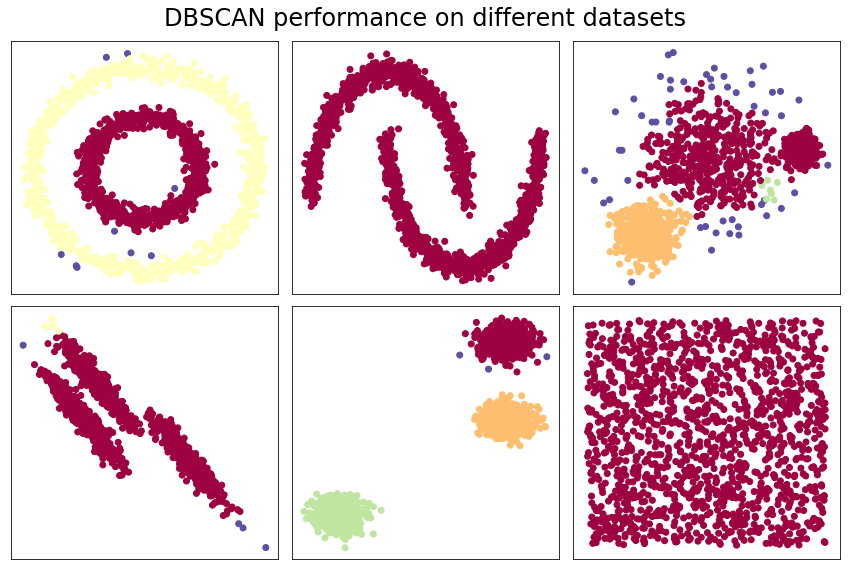

In [3]:
n_samples = 1500

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)[0]
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)[0]
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)[0]

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = X_aniso

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)[0]

no_structure = np.random.rand(n_samples, 2)

data = [
    (noisy_circles, {'eps': 0.08}),
    (noisy_moons, {}),
    (varied, {'eps': .75}),
    (aniso, {'eps': .45}),
    (blobs, {'eps': 1}),
    (no_structure, {'eps': 0.3})
]

plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=.02, right=.98, bottom=.02, top=.92, wspace=.05, hspace=.05)
plt.suptitle("DBSCAN performance on different datasets", fontsize=24)

for i in range(len(data)):
    dataset, conf = data[i][0], data[i][1]

    dbscan = DBSCAN(**conf)
    labels = dbscan.fit(dataset)

    unique_labels = np.unique(labels)
    colors = np.array([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels + 1))])

    plt.subplot(2, 3, i + 1)
    plt.scatter(dataset[:, 0], dataset[:, 1], color=colors[labels])
    plt.xticks(())
    plt.yticks(())
plt.show()